In [49]:
using Cairo
import Base.Sys
import Base.show
using Graphics
using Colors

In [15]:
z = zeros(UInt32,512,512);
surf = CairoImageSurface(z, Cairo.FORMAT_ARGB32)

Cairo.status(surf) == 0

pa = surf.ptr
surf.ptr = C_NULL

destroy(surf) == nothing

surf.ptr = pa
cr = Cairo.CairoContext(surf)

m1 = CairoMatrix(1, 0, 0, 1, 0, 0)
m2 = CairoMatrix(1.0,2.0,2.0,1.0,0.,0.)
m = get_matrix(cr)
m == m1
set_matrix(cr, m2)
get_matrix(cr) == m2
Graphics.reset_transform(cr)
get_matrix(cr) == m1
destroy(cr) == nothing

true

In [16]:
# some collection of some painting plus support functions

"""
function ngray(base::Int,digits::Int,value::Int)
Convert a value to a graycode with the given base and digits
"""
function ngray(base::Int,digits::Int,value::Int)
    baseN = zeros(Int,digits)
    gray = zeros(Int,1,digits)

	for i=1:digits
		baseN[i] = value % base
		value = div(value,base)
	end

	shift = 0
	for i=digits:-1:1
		gray[i] = (baseN[i] + shift) % base
		shift = shift + base - gray[i]
	end
	gray
end

"""
function hilbert_curve(c,x,y,lg,i1,i2)
recursive hilbert curve (2D), appends pairs of x,y to c, lg = dimension/length
"""
function hilbert_curve(c,x,y,lg,i1,i2)
    if lg == 1
        append!(c,[x,y])
    else
        lg = lg / 2;
        hilbert_curve(c,x+i1*lg,y+i1*lg,lg,i1,1-i2);
        hilbert_curve(c,x+i2*lg,y+(1-i2)*lg,lg,i1,i2);
        hilbert_curve(c,x+(1-i1)*lg,y+(1-i1)*lg,lg,i1,i2);
        hilbert_curve(c,x+(1-i2)*lg,y+i2*lg,lg,1-i1,i2);
    end
end


function hilbert_colored(surf)

    zscale = 8;
    n1 = 8;
    cr = CairoContext(surf)

    c = Float64[]
    hilbert_curve(c,0,0,64,0,0)

    move_to(cr,0,0)

    translate(cr,zscale/2,zscale/2)
    scale(cr,zscale,zscale)
    set_line_width(cr,zscale/2)
    set_line_cap(cr,Cairo.CAIRO_LINE_CAP_SQUARE)

    for k in zip(collect(1:2:(length(c)-2)),1:(length(1:2:(length(c)-2))))
        move_to(cr,c[k[1]],c[k[1]+1])
        line_to(cr,c[k[1]+2],c[k[1]+3])

        c1 = ngray(n1,3,k[2])
        set_source_rgb(cr,c1[1]/float(n1-1),c1[2]/float(n1-1),c1[3]/float(n1-1))
        stroke(cr)

    end
end


""" function hdraw(s,dim,zscale,linewidth)
draws a hilbert curve with dimension dim (power of 2) and scales the drawing with
zscale.
"""
function hdraw(s,dim,zscale,linewidth)

    cr = CairoContext(s)

    set_source_rgba(cr,0.0,0.0,1.0,0.5)

    set_line_width(cr,linewidth)
    set_line_cap(cr,Cairo.CAIRO_LINE_CAP_SQUARE)
    translate(cr,zscale/2,zscale/2)

    save(cr)
    c = Float64[]

    hilbert_curve(c,0,0,dim,0,0)

    scale(cr,zscale,zscale)

    move_to(cr,0,0)
    for k=1:div(length(c),2)
        line_to(cr,c[(k*2)-1],c[(k*2)])
    end

    stroke(cr)
    restore(cr)
end

"""
function simple_hist(data)
    simple histogram by population count in a Dict
"""
function simple_hist(data)
    # poor man's hist -> pop count in Dict

    pc = Dict()

    for d in data
        if d in keys(pc)
            pc[d] += 1
        else
            pc[d] = 1
        end
    end
    pc
end

"""
function matrix_read(surface)
	paint the input surface into a matrix image of the same size to access
	the pixels.
"""
function matrix_read(surface)
	w = Int(surface.width)
	h = Int(surface.height)
	z = zeros(UInt32,w,h)
	surf = CairoImageSurface(z, Cairo.FORMAT_ARGB32)

    cr = CairoContext(surf)
    set_source_surface(cr,surface,0,0)
    paint(cr)

    surf.data
end

matrix_read

In [17]:
surf = CairoImageSurface(z, Cairo.FORMAT_ARGB32)

cr = CairoContext(surf)
set_source_surface(cr,surface,0,0)
paint(cr)

LoadError: UndefVarError: surface not defined

In [24]:
WIDTH, HEIGHT = 256, 256

surface = CairoImageSurface(Cairo.FORMAT_ARGB32, WIDTH, HEIGHT)
ctx = CairoContext(surface)

ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

pat = Cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
pat.add_color_stop_rgba(1, 0.7, 0, 0, 0.5)  # First stop, 50% opacity
pat.add_color_stop_rgba(0, 0.9, 0.7, 0.2, 1)  # Last stop, 100% opacity

ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1)
ctx.set_source(pat)
ctx.fill()

ctx.translate(0.1, 0.1)  # Changing the current transformation matrix

ctx.move_to(0, 0)
# Arc(cx, cy, radius, start_angle, stop_angle)
ctx.arc(0.2, 0.1, 0.1, -math.pi / 2, 0)
ctx.line_to(0.5, 0.1)  # Line to (x,y)
# Curve(x1, y1, x2, y2, x3, y3)
ctx.curve_to(0.5, 0.2, 0.5, 0.4, 0.2, 0.8)
ctx.close_path()

ctx.set_source_rgb(0.3, 0.2, 0.5)  # Solid color
ctx.set_line_width(0.02)
ctx.stroke()

surface.write_to_png("example.png")  # Output to PNG

LoadError: type CairoContext has no field scale

In [41]:
using Colors
using Tk

win = Toplevel("Test", 400, 200)
c = Canvas(win)
pack(c, expand=true, fill="both")
ctx = getgc(c)

error during Tk callback: 
error during Tk callback: 
error during Tk callback: 


ERROR: MethodError: no method matching Vector{UInt8}(::Int64)
Closest candidates are:
  Array{T, N}(::BitArray{N}) where {T, N} at C:\Users\DJ\AppData\Local\Programs\Julia-1.7.2\share\julia\base\bitarray.jl:494
  Vector{T}(::Core.Compiler.AbstractRange{T}) where T at C:\Users\DJ\AppData\Local\Programs\Julia-1.7.2\share\julia\base\range.jl:1286
  Vector{T}(::AbstractRange{T}) where T at C:\Users\DJ\AppData\Local\Programs\Julia-1.7.2\share\julia\base\range.jl:1286
  ...
Stacktrace:
 [1] render_to_cairo(f::Tk.var"#9#10"{Canvas}, w::Tk.TkWidget, clipped::Bool)
   @ Tk C:\Users\DJ\.julia\packages\Tk\c8ZUf\src\tkwidget.jl:365
 [2] configure(c::Canvas)
   @ Tk C:\Users\DJ\.julia\packages\Tk\c8ZUf\src\tkwidget.jl:230
 [3] (::Tk.var"#15#26"{Canvas})(path::String)
   @ Tk C:\Users\DJ\.julia\packages\Tk\c8ZUf\src\tkwidget.jl:386
 [4] jl_tcl_callback(fptr::Ptr{Nothing}, interp::Ptr{Nothing}, argc::Int32, argv::Ptr{Ptr{UInt8}})
   @ Tk C:\Users\DJ\.julia\packages\Tk\c8ZUf\src\tkwidget.jl:142
 [5] t

LoadError: UndefRefError: access to undefined reference

In [48]:
c = CairoRGBSurface(256,256)
cr = CairoContext(c)

save(cr)
set_source_rgb(cr,0.8,0.8,0.8)    # light gray
rectangle(cr,0.0,0.0,256.0,256.0) # background
fill(cr)
restore(cr)

## original example, following here
xc = 128.0
yc = 128.0
radius = 100.0
angle1 = 45.0  * (pi/180.0)  # angles are specified
angle2 = 180.0 * (pi/180.0)  # in radians

set_line_width(cr, 10.0)
arc(cr, xc, yc, radius, angle1, angle2)
stroke(cr)

# draw helping lines
set_source_rgba(cr, 1, 0.2, 0.2, 0.6)
set_line_width(cr, 6.0)

arc(cr, xc, yc, 10.0, 0, 2*pi)
fill(cr)

arc(cr, xc, yc, radius, angle1, angle1)
line_to(cr, xc, yc)
arc(cr, xc, yc, radius, angle2, angle2)
line_to(cr, xc, yc)
stroke(cr)

## mark picture with current date
move_to(cr,0.0,12.0)
set_source_rgb(cr, 0,0,0)
show_text(cr,Libc.strftime(time()))
write_to_png(c,"sample_arc.png")

0

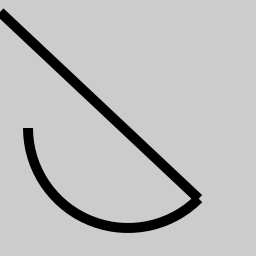

In [72]:
c = CairoRGBSurface(256, 256)
cr = CairoContext(c)

save(cr)
set_source_rgb(cr, 0.8, 0.8, 0.8)
rectangle(cr, 0.0, 0.0, 256.0, 256.0)
fill(cr)
restore(cr)

xc = 128.0
yc = 128.0
radius = 100.0
angle1 = 45.0 * (pi/180.0)
angle2 = pi

set_line_width(cr, 10.0)
arc(cr, xc, yc, radius, angle1, angle2)
stroke(cr)

move_to(cr, 0.0, 12.0)
arc(cr, xc, yc, radius, angle1, angle1)
#line_to(cr, xc, yc)
stroke(cr)

c